# Introduction

# Load Data

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

# Check File Size 

In [2]:
def check_fsize(dpath,s=30):
    """check file size
    Args:
    dpath: file directory
    s: string length in total after padding
    
    Returns:
    None
    """
    for f in os.listdir(dpath):
        print(f.ljust(s) + str(round(os.path.getsize(dpath+'/' + f) / 1000000, 2)) + 'MB')

In [16]:
check_fsize('./data')

sample_submission.csv.zip     1.19MB
test_identity.csv.zip         3.11MB
test_transaction.csv          613.19MB
train_transaction.csv         683.35MB
train_transaction.csv.zip     55.06MB
train_identity.csv.zip        3.17MB
test_identity.csv             25.8MB
train_identity.csv            26.53MB
test_transaction.csv.zip      49.63MB


In [6]:
def check_fline(fpath):
    """check total number of lines of file for large files
    
    Args:
    fpath: string. file path
    
    Returns:
    None
    
    """
    lines = subprocess.run(['wc', '-l', fpath], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines, end='', flush=True)

In [18]:
fs=['./data/train_transaction.csv', './data/train_identity.csv', './data/test_transaction.csv','./data/test_identity.csv']
[check_fline(s) for s in fs]

590541 ./data/train_transaction.csv
144234 ./data/train_identity.csv
506692 ./data/test_transaction.csv
141908 ./data/test_identity.csv


[None, None, None, None]

# Load Data

In [28]:
# Load sample training data
df_train_transac = pd.read_csv('./data/train_transaction.csv')
df_train_identity = pd.read_csv('./data/train_identity.csv')

(590540, 394)
(144233, 41)


In [48]:
# Show data shape
print(df_train_transac.shape)
print(df_train_identity.shape)

# Show data head
print(df_train_transac.head(2))
print(df_train_identity.head(2))

(590540, 394)
(144233, 41)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   

   card2  card3       card4  card5  ...  V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...   NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...   NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  

[2 rows x 394 columns]
   TransactionID  id_01    id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0  70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0  98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   

   id_09              ...                              id_31  id_32  \
0    NaN              ...                samsung browser 6.2   32.0   
1    NaN              ..

## Check Feature Type

In [21]:
def count_feature_type(df):
    return df.dtypes.value_counts()

In [31]:
print(count_feature_type(df_train_transac))
print(count_feature_type(df_train_identity)

float64    376
object      14
int64        4
dtype: int64
float64    23
object     17
int64       1
dtype: int64


# Explore Transaction Data
First take a closer look on transaction data. Start with the general data missing condition.

## Check Target Distribution

In [55]:
def check_cunique(df,cols):
    """check unique values for each column
    df: data frame. 
    cols: list. The columns of data frame to be counted
    """
    df_nunique = df[cols].nunique().to_frame()
    df_nunique = df_nunique.reset_index().rename(columns={'index': 'feat',0:'nunique'})
    return df_nunique

In [56]:
def feat_value_count(df,colname):
    """value count of each feature
    
    Args
    df: data frame.
    colname: string. Name of to be valued column
    
    Returns
    df_count: data frame.
    """
    df_count = df[colname].value_counts().to_frame().reset_index()
    df_count = df_count.rename(columns={'index':colname+'_values',colname:'counts'})
    return df_count

In [57]:
feat_value_count(df_train_transac,'isFraud')

,isFraud_values,counts
0,0,569877
1,1,20663


Obviously this is a imbalanced classification problem. Only 3.5% of data is of target 1.

## Check Missing Value 

In [42]:
def check_missing(df,cols=None,axis=0):
    """check data frame column missing situation
    Args
    df: data frame.
    cols: list. List of column names
    axis: int. 0 means column and 1 means row
    
    Returns
    missing_info: data frame. 
    """
    if cols != None:
        df = df[cols]
    missing_num = df.isnull().sum(axis).to_frame().rename(columns={0:'missing_num'})
    missing_num['missing_percent'] = df.isnull().mean(axis)*100
    return missing_num.sort_values(by='missing_percent',ascending = False) 

In [43]:
df_colmissing = check_missing(df_train_transac,cols=None,axis=0)
df_colmissing.head()

,missing_num,missing_percent
dist2,552913,93.628374
D7,551623,93.409930
D13,528588,89.509263
D14,528353,89.469469
D12,525823,89.041047


Some colunms have very high missing rate.

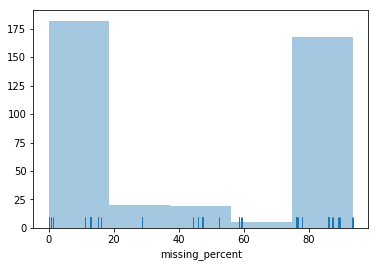

In [44]:
sns.distplot(df_colmissing.missing_percent, kde=False, rug=True)

In [46]:
df_rowmissing = check_missing(df_train_transac,cols=None,axis=1)
df_rowmissing.head()

,missing_num,missing_percent
522237,300,76.142132
522280,296,75.126904
474068,292,74.111675
31095,292,74.111675
474362,292,74.111675


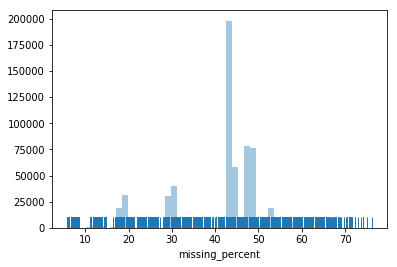

In [47]:
sns.distplot(df_rowmissing.missing_percent, kde=False, rug=True)

## Check feature unique value

In [27]:
df_nunique = check_cunique(df_train_transac,df_train_transac.select_dtypes(include=['object'].col)
df_nunique

,feat,nunique
0,ProductCD,5
1,card4,4
2,card6,4
3,P_emaildomain,59
4,R_emaildomain,60
5,M1,2
6,M2,2
7,M3,2
8,M4,3
9,M5,2


### Check ProductCD

In [33]:
feat_value_count(df_train_transac,'ProductCD')

,ProductCD_values,counts
0,W,439670
1,C,68519
2,R,37699
3,H,33024
4,S,11628


ProductCD: product code, the product for each transaction

Five category of products. And type 'W' wins in counts. 

### Check card4

In [49]:
feat_value_count(df_train_transac,'card4')

,card4_values,counts
0,visa,384767
1,mastercard,189217
2,american express,8328
3,discover,6651


OK, card4 means card type. I have to say that I never head discover card before.

### Check card6

In [51]:
feat_value_count(df_train_transac,'card6')

,card6_values,counts
0,debit,439938
1,credit,148986
2,debit or credit,30
3,charge card,15


Now some information.

**Credit cards** allow you to purchase items up to your credit limit. You can repay them within the month to avoid interest charges (if there is a grace period), or you can make smaller payments over a longer period of time which will result in interest charges.

**Charge cards** are similar to credit cards in that they allow you to pay for purchases up to your credit limit. Some charge cards do not have a predetermined credit limit and will approve larger purchases on a case-by-case basis. Charge cards require the balance to be paid back in a short period of time, usually within a month.

**Debit cards** are tied to a bank account from which funds are withdrawn for each purchase. Therefore, you will get a debit card from your financial institution where you have a personal or business checking or savings account.

### Check P_emaildomain

In [53]:
feat_value_count(df_train_transac,'P_emaildomain')

,P_emaildomain_values,counts
0,gmail.com,228355
1,yahoo.com,100934
2,hotmail.com,45250
3,anonymous.com,36998
4,aol.com,28289
5,comcast.net,7888
6,icloud.com,6267
7,outlook.com,5096
8,msn.com,4092
9,att.net,4033


purchaser and recipient email domain. Interesting, I think perhaps the final domain like .com/.jp will provide additional information

### Check R_emaildomain

In [54]:
feat_value_count(df_train_transac,'R_emaildomain')

,R_emaildomain_values,counts
0,gmail.com,57147
1,hotmail.com,27509
2,anonymous.com,20529
3,yahoo.com,11842
4,aol.com,3701
5,outlook.com,2507
6,comcast.net,1812
7,yahoo.com.mx,1508
8,icloud.com,1398
9,msn.com,852


I have to say that some email address looks pretty strange.

### Check M1

In [58]:
feat_value_count(df_train_transac,'M1')

,M1_values,counts
0,T,319415
1,F,25


M1-M9：match, such as names on card and address. I think this is quite straight forward. False would lead to high prob of fraud.

In [60]:
feat_value_count(df_train_transac,'addr1')

,addr1_values,counts
0,299.0,46335
1,325.0,42751
2,204.0,42020
3,264.0,39870
4,330.0,26287
5,315.0,23078
6,441.0,20827
7,272.0,20141
8,123.0,16105
9,126.0,15243
